<font size = "6"> Quantum Chemistry Simulations : $H_2$

<font size = "5"> Solving for the ground state of $H_2$ molecule using Variational Quantum EigenSolver 
<font size = "3"> <div align="left">  *Using statevector simulator*

In [1]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
#importing basic libraries
import numpy as np
import matplotlib.pyplot as plt


# Importing standard Qiskit libraries
from qiskit import qiskit
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit import IBMQ
from qiskit import QuantumCircuit, transpile, Aer


# Basic VQE Calculation
# Importing basic libraries and standard Qiskit libraries.
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.utils import QuantumInstance
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import TwoLocal
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel


#Importing Qiskit Librarires for VQE
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, L_BFGS_B, SPSA


#Importing libraries for PauliSum
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.quantum_info import SparsePauliOp


#Import Qiskit Nature Libararies
#from qiskit_nature.transformers import ActiveSpaceTransformer #ActiveSpaceTransformer Missing
from qiskit_nature.settings import settings
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter 
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver #Deprecation_Warning 
from qiskit_nature.circuit.library import HartreeFock, UCCSD, PUCCD
settings.dict_aux_operators =True

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [4]:
"""
Setup the molecular data for simulation. Note that this step requires an external program (this example uses the PySCF program) for HF and integral calculations

Some typical input parameters for quantum chemistry simulation : 

1. Cartesian coordinates with atomic labels (Positions of nuclei)
2. Charge (-1 : Anion, +1: Cation, 0:Neutral Molecule)
3. Multiplicity (1:singlet, 2:doublet; .....)
4. Basis set(sto-3g, minao, 6-31, cc-pvdz, ....)

"""
#Initiating the PySCF driver(for setup of quantum chemical calculations and Hartree-fock Calculation)
#Cartesian coordinates determine the position of the nucleus
#Charge  = 0 since its a neutral molecule
#Singlet state calculation - Multiplicity=1

molecule = Molecule(geometry=[['H',[0.,0.,0.]],['H',[0.,0.,0.735]]],charge=0,multiplicity=1)
print(molecule)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		H	[0.0, 0.0, 0.0]
		H	[0.0, 0.0, 0.735]


In [5]:
#import pyscf
#driver = PySCFDriver(unit = UnitsType.ANGSTROM, basis = 'sto-3g')
from qiskit_nature.drivers.second_quantization import (ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
driver = ElectronicStructureMoleculeDriver(molecule=molecule,basis="sto3g",driver_type=ElectronicStructureDriverType.PYSCF)

In [6]:
#Performing the setup calculation using PySCF and retrieve data from the calculations
es_problem = ElectronicStructureProblem(driver) #electronic structure problem

#Getting the second quantized Hamiltonian in molecular orbital form
second_q_op = es_problem.second_q_ops()
print(second_q_op.keys())
print("")
print(type(second_q_op['ElectronicEnergy']))
print("")
print(second_q_op['ElectronicEnergy'])

dict_keys(['ParticleNumber', 'ElectronicEnergy', 'DipoleMomentX', 'DipoleMomentY', 'DipoleMomentZ', 'AngularMomentum', 'Magnetization'])

<class 'qiskit_nature.operators.second_quantization.fermionic_op.FermionicOp'>

Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0. ...


In [7]:
"""
#Jordan Wigner Mapping
qubit_converter= QubitConverter(mapper=JordanWignerMapper())
qubit_op= qubit_converter.convert(second_q_op['ParticleNumber'])
print(qubit_op)
print(" ")

#Bravyi Kitaev Mapping
qubit_converter = QubitConverter(mapper=BravyiKitaevMapper())
qubit_op = qubit_converter.convert(second_q_op['ParticleNumber'])
print(qubit_op)
print(" ")

# In the minimal STO-3G basis set 4 qubits are required. 
# We can reduce the number of qubits by using the Parity Mapping, 
# Which allows for the removal of 2 qubits by exploiting known symmetries arising from the mapping

#Parity Mapping (with Two Qubit Reduction Off)
qubit_converter= QubitConverter(mapper=ParityMapper(), two_qubit_reduction=False)
qubit_op= qubit_converter.convert(second_q_op['ParticleNumber'], num_particles=es_problem.num_particles)
print(qubit_op)
print(" ")

#Parity Mapping (with Two Qubit Reduction On)
qubit_converter= QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op= qubit_converter.convert(second_q_op['ParticleNumber'], num_particles=es_problem.num_particles)
print(qubit_op)
"""

from qiskit.opflow import TwoQubitReduction

#Without Two Qubit Reduction
mapper = ParityMapper() #Set Mapper
hamiltonian = second_q_op['ParticleNumber']  #Set Hamiltonian
qubit_converter = QubitConverter(mapper,two_qubit_reduction=True)
qubit_op = qubit_converter.convert(hamiltonian)
print(qubit_op)
print()

#With Two Qubit Reduction
mapper = ParityMapper() #Set Mapper
hamiltonian = second_q_op['ParticleNumber']  #Set Hamiltonian
qubit_converter = QubitConverter(mapper,two_qubit_reduction=True)
num_particles = es_problem.num_particles
reducer = TwoQubitReduction(num_particles)
qubit_op = qubit_converter.convert(hamiltonian)
qubit_op = reducer.convert(qubit_op)
print(qubit_op)

2.0 * IIII
- 0.5 * IIIZ
- 0.5 * IIZZ
- 0.5 * IZZI
- 0.5 * ZZII

1.9999999999999993 * II


In [10]:

#Setting up for the VQE Calculation
#Setting the optimizer(COBYLA, L_BFGS_B (L-BFGS-B), and etc.)
optimizer = SLSQP(maxiter=100) #SLSQP optimizer is a default for Qiskit


"""
#Setting the number of basis set and the number of particles
num_spin_orbitals=4
num_particles=(1,1)
"""
"""
"""
# Get properties
properties = driver.run()
num_particles = (properties.get_property("ParticleNumber").num_particles)
num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)
print(num_particles)
print(num_spin_orbitals)
print()

#Setting the number of basis set and the number of particles
num_spin_orbitals = es_problem.num_spin_orbitals
num_particles = es_problem.num_particles
print(num_particles)
print(num_spin_orbitals)

"""
"""

#Setting the intial state as the HF State |1100> or |1010> in Qiskit Convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

#Set the UCCSD Ansatz to prepare the state more accurately
ansatz = UCCSD(qubit_converter, num_particles, num_spin_orbitals, initial_state=initial_state)

#Set the VQE Solver
vqe_solver = VQE(ansatz = ansatz, optimizer = optimizer, quantum_instance=QuantumInstance(backend=Aer.get_backend("statevector_simulator")))

(1, 1)
4

(1, 1)
4


In [11]:
#Set the solver for the exact value of ground state energy for reference
#Perform the VQE calculation using GroundStateEigenSolver
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)
print(dir(res))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_aux_operator_eigenvalues', '_computed_dipole_moment', '_computed_energies', '_eigenenergies', '_eigenstates', '_extracted_transformer_dipoles', '_extracted_transformer_energies', '_hartree_fock_energy', '_magnetization', '_nuclear_dipole_moment', '_nuclear_repulsion_energy', '_num_particles', '_raw_result', '_reverse_dipole_sign', '_total_angular_momentum', 'aux_operator_eigenvalues', 'combine', 'computed_dipole_moment', 'computed_energies', 'dipole_moment', 'dipole_moment_in_debye', 'eigenenergies', 'eigenstates', 'electronic_dipole_moment', 'electronic_energies', 'extracted_transformer_dipole', 

In [12]:
print("Using VQE  \n\n\n{}".format(res))

Using VQE  


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [13]:
#Set the solver for the exact value of ground state energy for reference
# Performing reference calculation
solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(qubit_converter, solver)
res= calc.solve(es_problem)
print("Using NumpyMinimumEigenSolver for reference  \n\n\n{}".format(res))

Using NumpyMinimumEigenSolver for reference  


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [26]:
# Constructing PE Curve
# Calculating the molecular energy while elongating H-H bond length

h2_length = np.arange(0.3,2,0.1)
hf_energy_list=[]
uccsd_energy_list=[]
nuclear_repulsion_energy_list = []
optimizer = SLSQP(maxiter=100)

for bond_length in h2_length:
    molecule = Molecule(geometry=[['H',[0.,0., 0.]],['H',[0.,0.,bond_length]]], charge=0, multiplicity=1)
    #driver = PySCFDriver(atom='H 0.0 0.0 0.0; H 0.0 0.0 '+str(bond_length), unit=UnitsType.ANGSTROM, basis='sto6g')
    driver = ElectronicStructureMoleculeDriver(molecule=molecule,basis="sto3g",driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)
    quantum_instance = QuantumInstance(backend =Aer.get_backend('statevector_simulator'))
    vqe_solver = VQEUCCFactory(quantum_instance)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    res = calc.solve(es_problem)
    hf_energy_list += [res.hartree_fock_energy]
    uccsd_energy_list += [res.total_energies[0]]
    nuclear_repulsion_energy_list += [res.nuclear_repulsion_energy]

In [16]:
"""
print(type(res))
print("")
print(dir(res))
print("")
print(res)
"""

'\nprint(type(res))\nprint("")\nprint(dir(res))\nprint("")\nprint(res)\n'

In [17]:
"""
#HF_Energy
print(res.hartree_fock_energy)
print(res._hartree_fock_energy)
print()

#Electronic Ground State Energy
print(res.groundenergy)
print(res.electronic_energies)
print(res._eigenenergies)
print(res.computed_energies)
print()

#UCCSD_Energy
print(res.total_energies[0])
print(res.total_energies)
print()


print(res._extracted_transformer_energies)
print(res.extracted_transformer_energy)
print()

#Nuclear Repulsion Energy
print(res.nuclear_repulsion_energy) 

#Eigenstate
print(res._eigenstates)
"""

'\n#HF_Energy\nprint(res.hartree_fock_energy)\nprint(res._hartree_fock_energy)\nprint()\n\n#Electronic Ground State Energy\nprint(res.groundenergy)\nprint(res.electronic_energies)\nprint(res._eigenenergies)\nprint(res.computed_energies)\nprint()\n\n#UCCSD_Energy\nprint(res.total_energies[0])\nprint(res.total_energies)\nprint()\n\n\nprint(res._extracted_transformer_energies)\nprint(res.extracted_transformer_energy)\nprint()\n\n#Nuclear Repulsion Energy\nprint(res.nuclear_repulsion_energy) \n\n#Eigenstate\nprint(res._eigenstates)\n'

In [27]:
Numpy_EigenSolver = []
for bond_length in h2_length:
    
    molecule = Molecule(geometry=[['H',[0.,0., 0.]],['H',[0.,0.,bond_length]]], charge=0, multiplicity=1)
    driver = PySCFDriver(atom='H 0.0 0.0 0.0; H 0.0 0.0 '+str(bond_length), unit=UnitsType.ANGSTROM, basis='sto6g')
    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)
    
    #Set the solver for the exact value of ground state energy for reference
    solver = NumPyMinimumEigensolver()
    # Performing reference calculation
    calc = GroundStateEigensolver(qubit_converter, solver)
    res= calc.solve(es_problem)
    Numpy_EigenSolver += [res.total_energies[0]]

-1.1173490349902795
0.7000000000000002

-1.136189454011311
0.7000000000000002

-1.1449790794982975
0.7000000000000002


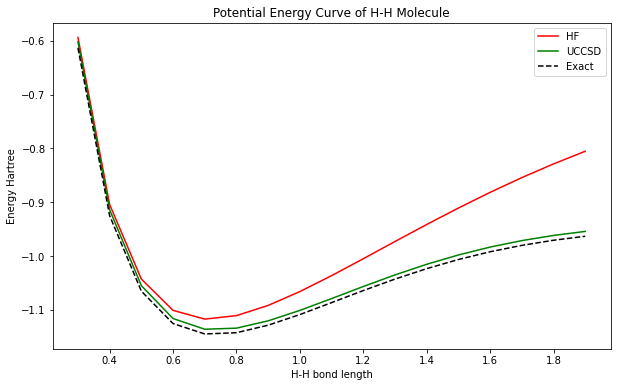

In [30]:
plt.figure(figsize=(10,6)) 
plt.plot(h2_length, hf_energy_list, color='red', label='HF')
print(min(hf_energy_list))
print(h2_length[np.argmin(hf_energy_list)])
print()

plt.plot(h2_length, uccsd_energy_list, color='green', label='UCCSD')
print(min(uccsd_energy_list))
print(h2_length[np.argmin(uccsd_energy_list)])
print()

plt.plot(h2_length, Numpy_EigenSolver, color='black', label='Exact', linestyle='dashed')
print(min(Numpy_EigenSolver))
print(h2_length[np.argmin(Numpy_EigenSolver)])


plt.title("Potential Energy Curve of H-H Molecule")
plt.xlabel("H-H bond length")
plt.ylabel("Energy Hartree")
plt.legend()

#UCCSD converges at the dissociation limit while HF doesn't

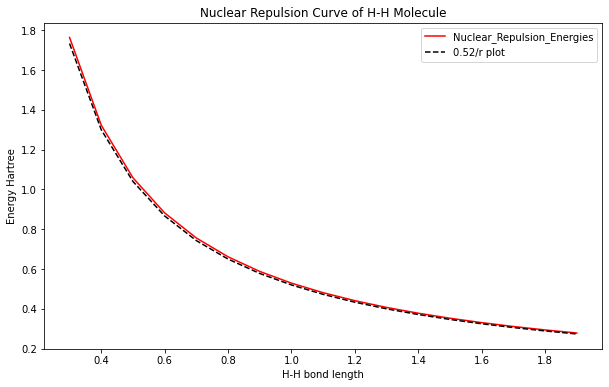

In [32]:
plt.figure(figsize=(10,6))
plt.plot(h2_length, nuclear_repulsion_energy_list, color='red', label='Nuclear_Repulsion_Energies')

#Checking if the graph below is an 1/r curve or not
l = np.arange(0.3,2,0.1)
array = []
for r in l:
    array.append(0.52/(r)) # 0.53 is a hit and trial attempt

plt.plot(l, array, color='black', alpha = 1, linestyle='dashed',  label='0.52/r plot')
plt.title("Nuclear Repulsion Curve of H-H Molecule")
plt.xlabel("H-H bond length")
plt.ylabel("Energy Hartree")
plt.legend()